# Chapter 3

## Set Up

### Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

## 3.1 Sampling from a grid-approximate posterior

Posterior for the globe tossing model.

In [117]:
def calculate_posterior_from_globe_tossing(n_water, n_obs, prior_rv=None, n_grid=1000):
    "Calculate grid approximation of posterior for given observations and prior (defaults to unifrom)"
    if not prior_rv:
        prior_rv = stats.uniform()
    
    p_grid = np.linspace(0, 1, n_grid)
    prior = prior_rv.pdf(p_grid)
    likelihood = stats.binom.pmf(n_water, n_obs, p_grid)

    posterior = likelihood * prior
    posterior /= posterior.sum()

    return posterior, p_grid

In [118]:
posterior, p_grid = calculate_posterior_from_globe_tossing(6, 9)

Sample the posterior

In [119]:
n_sample = 10000
samples = np.random.choice(p_grid, size=n_sample, p=posterior, replace=True)

Plot samples and their distribution.

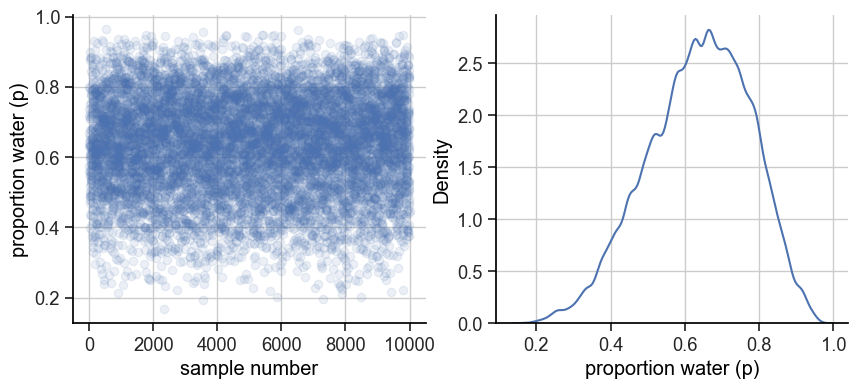

In [120]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

axs[0].scatter(np.arange(n_sample), samples, alpha=0.1)
axs[0].set(
    xlabel="sample number",
    ylabel="proportion water (p)",
)

sns.kdeplot(samples, bw_adjust=0.5, ax=axs[1])
axs[1].set(
    xlabel="proportion water (p)",
);

## 3.2 Sampling to summarize

In [7]:
# sum probability below p=0.5
np.sum(posterior[p_grid < 0.5])

0.17187458902022873

In [8]:
# do the same using posterior sample
(samples < 0.5).mean()

0.1688

In [9]:
# maximum a posteriori estimate
p_grid[np.argmax(posterior)]

0.6666666666666666

Let's calculate the posterior for an observation of 3 waters.

In [10]:
posterior, p_grid = calculate_posterior_from_globe_tossing(3, 3)
samples = np.random.choice(p_grid, size=10000, p=posterior, replace=True)

Calculate the loss for a given estimate of $p$ given an absolute difference loss function

In [11]:
p = 0.5
np.sum(posterior * np.abs(p - p_grid))

0.31287518749981214

We can do this for a grid of p values to plot the loss

In [12]:
def calculate_loss(p, posterior, posterior_grid, loss_function):
    """
    p: array of shape (m,)
    posterior: array of shape (n,)
    posterior_grid: grid of shape (n,)
    loss_function: function that gives elementwise loss(a, b) for arrays a, b of same shape
    """
    # create arrays pv = (p.T, p.T, ...).T and gridv = (grid, grid,...) of shape (n, m)
    pv, gridv = np.meshgrid(p, posterior_grid)

    # get all combinations of loss and weight by probability density
    # result is loss for all values of p, shape (m,)
    loss = posterior @ loss_function(pv, gridv)

    return loss

In [13]:
def absolute_diff(a, b):
    return np.abs(a - b)


def squared_diff(a, b):
    return (a - b) ** 2


p_val = np.linspace(0, 1, 100)
abs_diff_loss = calculate_loss(p_val, posterior, p_grid, absolute_diff)
squared_diff_loss = calculate_loss(p_val, posterior, p_grid, squared_diff)

Plot the different losses against p values as well as the posterior distribution

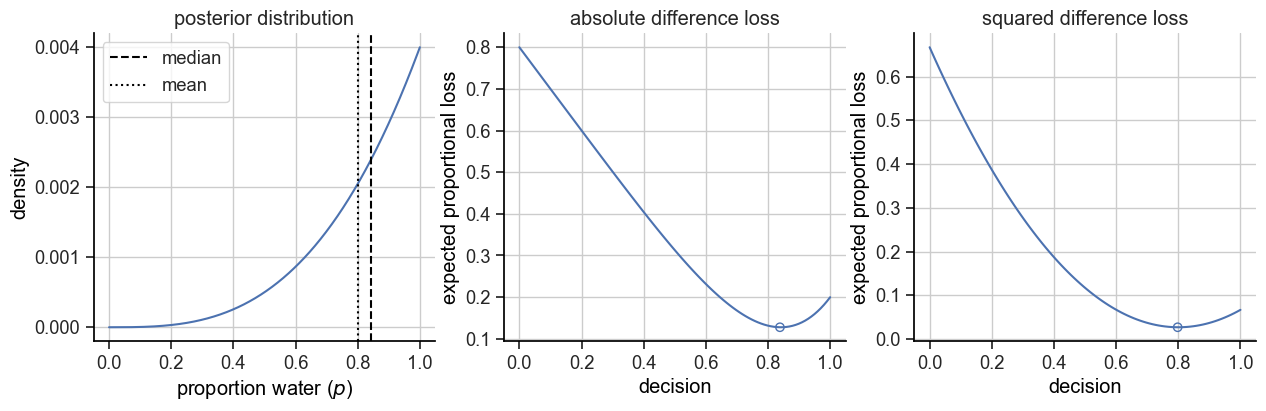

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 4))

# plot posterior distribution with its mean and median
ax1.plot(p_grid, posterior)

median = np.median(samples)
ax1.axvline(median, ls="--", color="black", label="median")

mean = np.mean(samples)
ax1.axvline(mean, ls=":", color="black", label="mean")

ax1.set(
    title="posterior distribution",
    xlabel="proportion water ($p$)",
    ylabel="density",
)
ax1.legend()

# plot the losses
losses = {
    "absolute difference": abs_diff_loss,
    "squared difference": squared_diff_loss,
}
for ax, (loss_name, loss) in zip((ax2, ax3), losses.items()):
    # plot loss
    ax.plot(p_val, loss)

    # plot best loss
    best_loss = np.min(loss)
    p_best = p_val[np.argmin(loss)]
    ax.scatter(p_best, best_loss, edgecolor="b", facecolor="none")

    ax.set(
        title=f"{loss_name} loss",
        xlabel="decision",
        ylabel="expected proportional loss",
    );

## 3.3 Sampling to simulation prediction

Simulate sampling from a binomial distribution

In [15]:
# actual probabilities
stats.binom.pmf(np.arange(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

In [16]:
# compare with sampling
n_sample = 100000
dummy_obs = stats.binom.rvs(size=n_sample, n=2, p=0.7)

_, counts = np.unique(dummy_obs, return_counts=True)
(counts / n_sample).round(3)

array([0.09 , 0.417, 0.493])

A histogram of a sample with more tosses. 

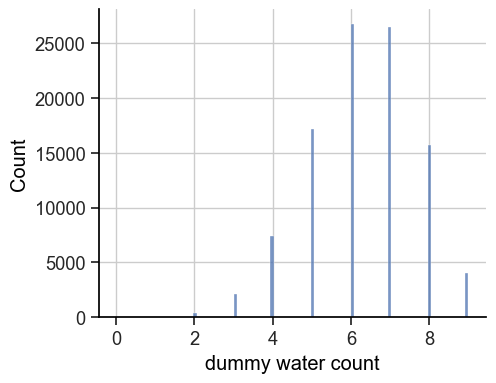

In [17]:
n_sample = 100000
dummy_obs = stats.binom.rvs(size=n_sample, n=9, p=0.7)

fig, ax = plt.subplots(figsize=(5, 4))

sns.histplot(dummy_obs, ax=ax)
ax.set(xlabel="dummy water count");

Now let's try sampling from a posterior predictive distribution

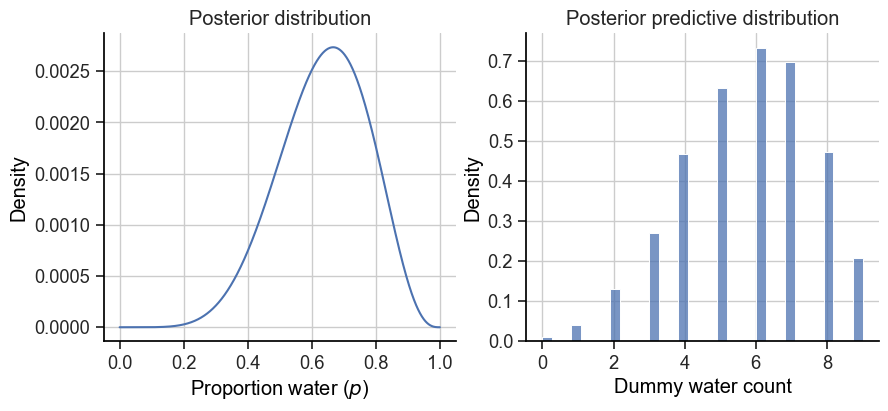

In [18]:
posterior, p_grid = calculate_posterior_from_globe_tossing(6, 9)

n_samples = 10000
post_samples = np.random.choice(p_grid, size=n_samples, replace=True, p=posterior)
pp_samples = stats.binom.rvs(n=9, p=post_samples, size=n_samples)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

# plot posterior dist
ax1.plot(p_grid, posterior)
ax1.set(
    title="Posterior distribution",
    xlabel="Proportion water ($p$)",
    ylabel="Density",
)

# posterior predictive distribution
sns.histplot(pp_samples, stat="density", ax=ax2)
ax2.set(title="Posterior predictive distribution", xlabel="Dummy water count");

# Exercises

## Easy

In [70]:
posterior, p_grid = calculate_posterior_from_globe_tossing(6, 9)

# sample from the posterior
np.random.seed(100)
samples = np.random.choice(p_grid, size=10000, p=posterior, replace=True)

Plot posterior for sense checks

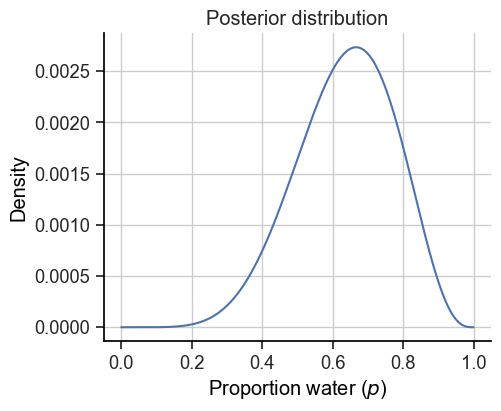

In [72]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(p_grid, posterior)
ax.set(
    title="Posterior distribution",
    xlabel="Proportion water ($p$)",
    ylabel="Density",
);

### 3E1

How much posterior probability lies below $p=0.2$?

---

In [45]:
(samples < 0.2).mean()

0.001

### 3E2

How much posterior probability lies above $p = 0.8$?

---

In [37]:
(samples > 0.8).mean().round(3)

0.1209

### 3E3

How much posterior probability lies between $p = 0.2$ and $p = 0.8$?

---

From the above it's 0.878, but to calculate it explicitly:

In [43]:
((samples > 0.2) & (samples < 0.8)).mean().round(3)

0.878

### 3E4

20% of the posterior probability lies below which value of $p$?

---

In [42]:
np.percentile(samples, 20).round(3)

0.516

### 3E5

20% of the posterior probability lies above which value of $p$?

---

In [46]:
np.percentile(samples, 80).round(3)

0.76

### 3E6

Which values of $p$ contain the narrowest interval equal to 66% of the posterior probability?

---

I don't have their HPDI package, but I can quickly find an approximate solution

In [75]:
def calculate_hpdi(samples, prob):
    "Get highest posterior density interval from samples"
    perc_lower = np.linspace(0, 100 * (1 - prob), 1000)
    perc_upper = perc_lower + 100 * prob

    perc = np.c_[perc_lower, perc_upper]

    interval = np.percentile(samples, perc)
    interval_width = interval[:, 1] - interval[:, 0]

    idx_best = np.argmin(interval_width)
    interval_best = interval[idx_best]
    perc_best = perc[idx_best]

    return interval_best, perc_best

In [77]:
interval, perc = calculate_hpdi(samples, prob=0.66)

print("Narrowest interval: ", interval.round(3))
print("Percentiles: ", perc.round(3))

Narrowest interval:  [0.517 0.789]
Percentiles:  [20.08 86.08]


### 3E7

Which values of $p$ contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?

---

I think this wants the central 66% interval.

In [69]:
lower = (100 - 66) / 2
upper = (100 + 66) / 2
print("Interval: ", np.percentile(samples, [lower, upper]).round(3))

Interval:  [0.498 0.773]


## Medium

### 3M1

Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

---

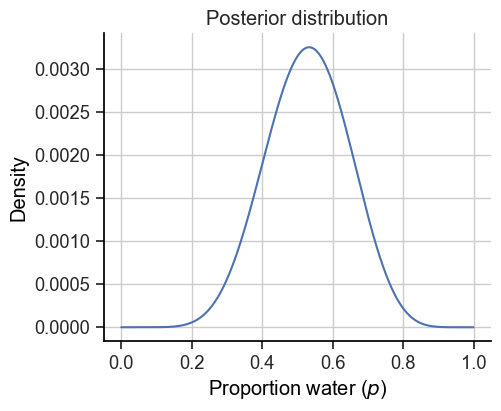

In [135]:
posterior, p_grid = calculate_posterior_from_globe_tossing(8, 15)

# plot the posterior
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(p_grid, posterior)
ax.set(
    title="Posterior distribution",
    xlabel="Proportion water ($p$)",
    ylabel="Density",
);

### 3M2

Draw 10,000 samples from the grid approximation from above. Then use the sample to calculate the 90% HPDI for $p$.

---

In [101]:
samples = np.random.choice(p_grid, size=10000, p=posterior, replace=True)

interval, perc = calculate_hpdi(samples, prob=0.9)

print("HPDI: ", interval.round(3))
print("Percentiles: ", perc.round(3))

HPDI:  [0.332 0.717]
Percentiles:  [ 4.775 94.775]


### 3M3

Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in $p$. What is the probability of observing 8 water in 15 tosses?

---

We sample from a binomial distribution using the posterior samples for the probabilities. 

In [106]:
n_samples = len(samples)
posterior_predictive_samples = stats.binom.rvs(n=15, p=samples, size=n_samples)

print("Probability of 8 water: ", (posterior_predictive_samples == 8).mean().round(3))

Probability of 8 water:  0.143


### 3M4 

Using the posterior distribution constructed from the new (8/15) data, now calculate the probability of observing 6 water in 9 tosses.

---

We use the same posterior samples but change the parameters of the Binomial distribution we are sampling

In [105]:
posterior_predictive_samples = stats.binom.rvs(n=9, p=samples, size=n_samples)

print("Probability of 6 water from 9 tosses: ", (posterior_predictive_samples == 6).mean().round(3))

Probability of 6 water from 9 tosses:  0.172


### 3M5

Start over at 3M1, but now use a prior that is zero below $p = 0.5$ and a constant above $p = 0.5$. This corresponds to prior information that a majority of the Earth’s surface is water. Repeat each problem above and compare the inferences (using both priors) to the true value $p = 0.7$.

---

First calculate and plot the posterior from 8 waters out of 15 tosses.

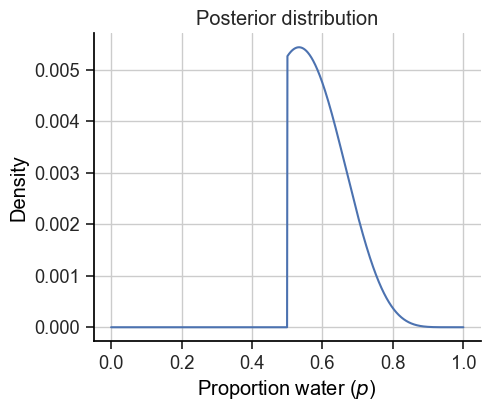

In [137]:
prior_rv = stats.uniform(0.5, 0.5)
posterior, p_grid = calculate_posterior_from_globe_tossing(8, 15, prior_rv)

# plot the posterior
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(p_grid, posterior)
ax.set(
    title="Posterior distribution",
    xlabel="Proportion water ($p$)",
    ylabel="Density",
);

Now get the HPDI - obviously from the plot above this will just be the interval starting at 0.5.

In [122]:
samples = np.random.choice(p_grid, size=10000, p=posterior, replace=True)

interval, perc = calculate_hpdi(samples, prob=0.9)

print("HPDI: ", interval.round(3))
print("Percentiles: ", perc.round(3))

HPDI:  [0.501 0.709]
Percentiles:  [ 0. 90.]


Now the posterior predictive sample

In [125]:
n_samples = len(samples)
posterior_predictive_samples = stats.binom.rvs(n=15, p=samples, size=n_samples)

print("Probability of 8 water from 15 tosses: ", (posterior_predictive_samples == 8).mean().round(3))

Probability of 8 water from 15 tosses:  0.154


In [126]:
posterior_predictive_samples = stats.binom.rvs(n=9, p=samples, size=n_samples)

print("Probability of 6 water from 9 tosses: ", (posterior_predictive_samples == 6).mean().round(3))

Probability of 6 water from 9 tosses:  0.229


The true value is 0.7, so the true probabilities are:

In [129]:
p = 0.7
print("Probability of 8 water from 15 tosses: ", stats.binom.pmf(n=15, k=8, p=p).round(3))
print("Probability of 6 water from 9 tosses: ", stats.binom.pmf(n=9, k=6, p=p).round(3))

Probability of 8 water from 15 tosses:  0.081
Probability of 6 water from 9 tosses:  0.267


The second prior does a better job at modelling the true value because it allows us to disregard the possibility that $p < 0.5$, which would otherwise be reasonably likely given the observed data. 

### 3M6

Suppose you want to estimate the Earth’s proportion of water very precisely. Specifically, you want the 99% percentile interval of the posterior distribution of $p$ to be only 0.05 wide. This means the distance between the upper and lower bound of the interval should be 0.05. How many times will you have to toss the globe to do this?

---

We simulate taking observations one at a time, updating the posterior, and finding the width of the central 99% density interval. To understand the variation we simulate doing this 1000 times simultaneously.

In [353]:
def calculate_interval_width_by_number_of_observations(n_sim, max_obs, p=0.7, density=99, prior_rv=None, n_grid=1000):
    if not prior_rv:
        prior_rv = stats.uniform()

    p_grid = np.linspace(0, 1, n_grid)
    prior = prior_rv.pdf(p_grid)

    # we broadcast these for the multiple simulations
    p_grids = np.array([p_grid] * n_sim)
    posteriors = np.array([prior] * n_sim)

    widths = np.empty((max_obs, n_sim))
    for obs_num in range(max_obs):
        obs = stats.bernoulli.rvs(p=p, size=n_sim)
        obs_broadcast = np.array([obs] * n_grid).T

        likelihoods = stats.bernoulli.pmf(obs_broadcast, p_grids)

        # update
        posteriors = likelihoods * posteriors
        posteriors = (posteriors / posteriors.sum(axis=1, keepdims=True))

        # get width of 99% density interval
        posterior_cdfs = np.cumsum(posteriors, axis=1)
        
        perc_lower = (1 - density/100) / 2
        lower_idx = np.argmin(np.abs(posterior_cdfs - perc_lower), axis=1)
        lower = p_grid[lower_idx]
    
        perc_upper = (1 + density/100) / 2
        upper_idx = np.argmin(np.abs(posterior_cdfs - perc_upper), axis=1)
        upper = p_grid[upper_idx]

        widths[obs_num, :] = upper - lower
    
    return widths

In [357]:
uniform_widths = calculate_interval_width_by_number_of_observations(n_sim=1000, max_obs=5000)

step_prior = stats.uniform(0.5, 0.5)
step_widths = calculate_interval_width_by_number_of_observations(n_sim=1000, max_obs=5000, prior_rv=step_prior)

Plot the mean interval width against number of observations with 90% density region.

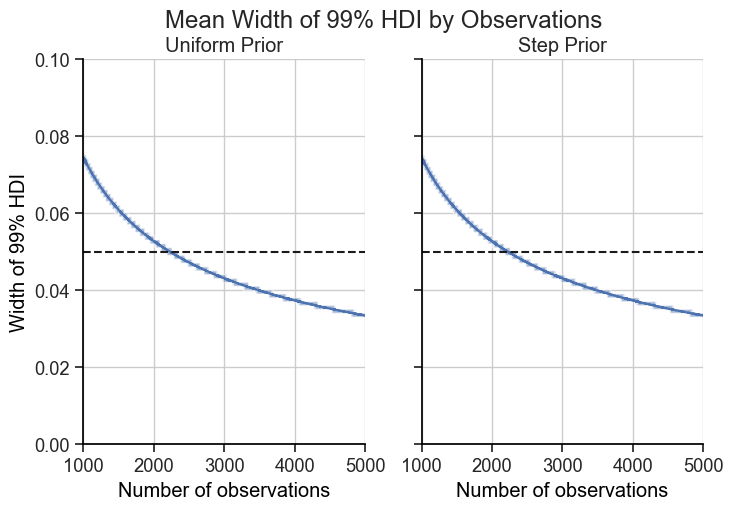

In [371]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 5), sharey=True)

for widths, ax in zip((uniform_widths, step_widths), (ax1, ax2)): 
    ax.plot(widths.mean(axis=1), label="mean interval width")
    ax.fill_between(
        x=range(widths.shape[0]),
        y2=np.percentile(uniform_widths, 5, axis=1),
        y1=np.percentile(uniform_widths, 95, axis=1),
        alpha=0.5,
        label="90% density",
    )
    ax.axhline(0.05, ls="--", color="k", label="target width")

    ax.set(
        xlim=[1000, 5000],
        ylim=[0, 0.1],
        xlabel="Number of observations",
    )

ax1.set(
    ylabel="Width of 99% HDI",
    title="Uniform Prior"
)
ax2.set(title="Step Prior")

fig.suptitle("Mean Width of 99% HDI by Observations");

You can see that there is not difference between the 2 priors at this points.

Let's find the point at which the interval becomes narrower than 0.05. We actually just find the point where it is closest to 0.05 - this is off by at most 1.

In [383]:
n_obs_for_width_below_threshold_uniform = np.argmin(np.abs(uniform_widths - 0.05), axis=0)
n_obs_for_width_below_threshold_step = np.argmin(np.abs(step_widths - 0.05), axis=0)

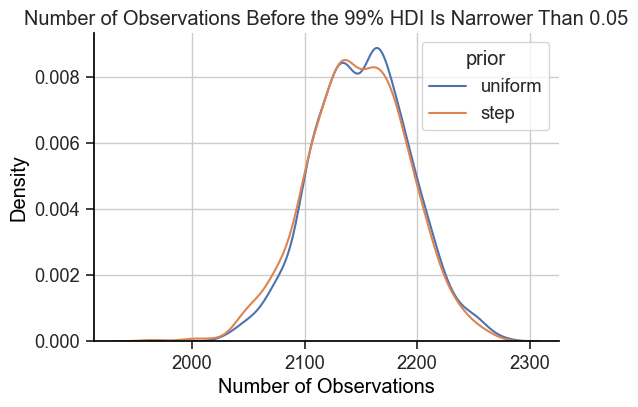

In [388]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.kdeplot(n_obs_for_width_below_threshold_uniform, label="uniform", ax=ax)
sns.kdeplot(n_obs_for_width_below_threshold_step, label="step", ax=ax)

ax.set(
    xlabel="Number of Observations",
    title="Number of Observations Before the 99% HDI Is Narrower Than 0.05"
)
ax.legend(title="Prior");

In [392]:
print(f"Mean number of observations: {n_obs_for_width_below_threshold_step.mean():.0f}±{n_obs_for_width_below_threshold_step.std():.0f}")

Mean number of observations: 2147±44
